# TRPO

## 一、简介

之前介绍的基于策略的方法包括策略梯度算法和Actor-Critic 算法。

这些算法虽然简单、直观，但在实际应用过程中会遇到训练不稳定的情况。

回顾一下基于策略的方法：参数化智能体的策略，并设计衡量策略好坏的目标函数，
通过梯度上升的方法来最大化这个目标函数，使得策略最优。

具体来说，假设策略为$\pi_\theta(a|s)$，参数为$\theta$，目标函数为:

$J(\theta)=E_{s_0}[V^{\pi_\theta}(s_0)]=E_{\pi_\theta}[\Sigma_{t=0}\gamma^tr(s_t,a_t)]$，

基于策略的方法目标：找到$\theta^*=argmax_\theta J(\theta)$

但是这种算法有一个明显的缺点：当策略网络是深度模型时，
沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果

针对以上问题，我们考虑在更新时找到一块信任区域（trust region），
在这个区域上更新策略时能够得到某种策略性能的安全性保证，
这就是信任区域策略优化
（trust region policy optimization，TRPO）
算法的主要思想。

TRPO 算法在 2015 年被提出，它在理论上能够保证策略学习的性能单调性，
并在实际应用中取得了比策略梯度算法更好的效果。

## 二、策略目标（这里懒得推了）：


<img src="./media/img.png" style="zoom:60%;">

然后是一堆看不懂的数学公式，直接看一下伪代码吧：

话说共轭梯度是啥......

<img src="./media/img_1.png" style="zoom:60%;">
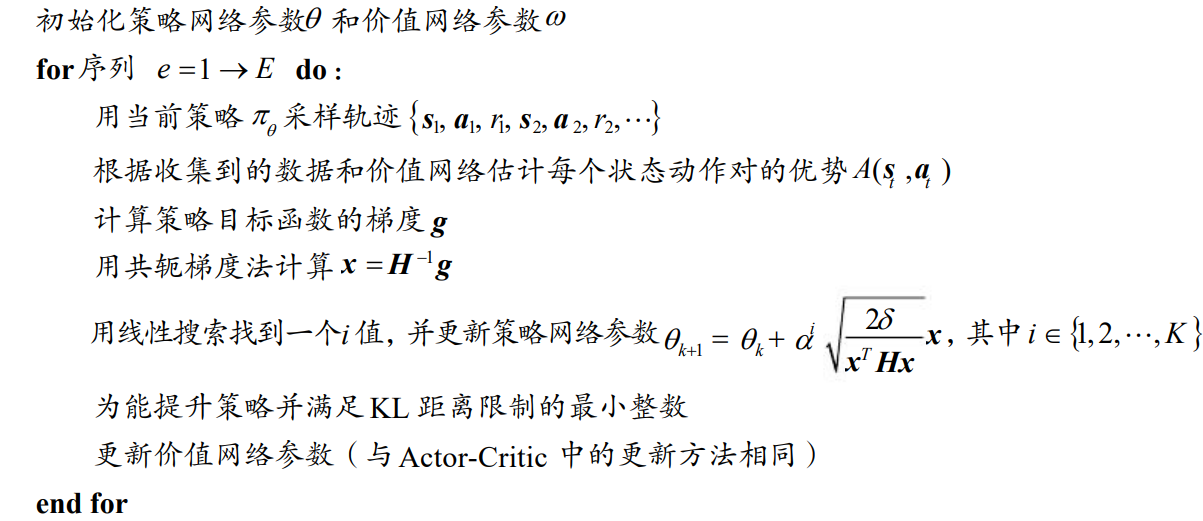

直接看代码实现吧，共轭梯度的推导什么的，一无所知啊，看看作用是什么吧先QAQ

三、代码实现

In [2]:
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
from Hands_on_RL_Note import rl_utils
import copy

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x),dim=1)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class TRPO:
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda # GAE 参数
        self.kl_constraint = kl_constraint # KL 距离最大限制
        self.alpha = alpha # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists,
        new_action_dists)) # 计算平均 KL 距离
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL 距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector